In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys # lets us exit functions when wrong user input provided

%matplotlib inline

In [2]:
def clean_nan(df, na_col, val_col):
    """
    Takes one of our year dataframes and cleans out nan values according to the rules discussed in step 5, below.
    Drops NaN in na_col where val_col is also NaN.
    Changes NaN in na_col where val_col is a value.
    This is just a convenience function. I will use it at least twice in the project.
    This keeps my code clean and will let me alter the cleaning method for all affected dataframes in one go, if necessary.
    """
    new_df = df.copy()
    new_df.loc[(new_df[na_col].isnull()) & (~new_df[val_col].isnull()),na_col] = 'None'
    new_df.dropna(subset = [na_col, val_col], inplace = True)
    none_count = (new_df[na_col] == 'None').sum()
    print('DF was {} rows long.\nNow {} rows.\n{} "None" values in {}, now.'.format(df.shape[0], new_df.shape[0], none_count, na_col))
    return new_df

In [3]:
def refactor_frames(df1, df2, split_col, split_vals, combine_col, combine_val):
    """
    Takes two frames, splits them on one dimension then recombines them on a second dimension.
    Original use case was taking two frames of two different years and returning one frame with both years but only one Country.
    Calling this function twice would turn two year frames including all countries into two country frames including all years.
    """
    df1_new = df1[df1[combine_col] == combine_val].copy()
    df2_new = df2[df2[combine_col] == combine_val].copy()
    
    df1_new[split_col] = split_vals[0]
    df2_new[split_col] = split_vals[1]
    
    df_combined = pd.concat([df1_new, df2_new], axis = 0)
    return df_combined

In [4]:
def find_mutual_values(df, col1, col2, transforms):
    """
    Takes a dataframe, a column with lists for values and a column with segments to compare.
    Returns the same dataframe with the list column transformed to eliminate list members that don't appear in all segments
    of the col2 variable. Also transforms some values that are conceptually the same among segments by semantically different.
    (i.e. HTML and CSS as separate list members are merged into one HTML/CSS member)
    """
    df_new = df.copy()
    
    # Step 1: Transform values using transforms
    df_new[col1] = df_new[col1].apply(lambda x: [transforms[a] if a in transforms.keys() else a for a in x])
    
    # Step 2: Reduce col1 lists so that they only include vals that appear across all segments
    segment_lists = [] # this list contains a list of col1 values in each segment
    for segment in df_new[col2].unique():
        df_col2 = df_new[df_new[col2] == segment]
        vals = list(dict.fromkeys(df_col2[col1].sum()))
        segment_lists.append(vals)
    
    # Using set(a).intersection(b) to find values shared by all segments
    # Set up contrast so that we only have to convert the first list to set one time
    contrast = set(segment_lists[0])
    for i in range(1,len(segment_lists)):
        # Iterate through the remaining members of segment_lists, contrasting with segment_lists[0] each time
        # This will trim segment_lists[0] each time a new member lacks any of its values.
        shared = contrast.intersection(segment_lists[i])
    
    df_new[col1] = df_new[col1].apply(lambda x: list(dict.fromkeys([a for a in x if a in shared])))
    
    return df_new

In [5]:
def list_to_value_counts(df, col1, col2 = None, transforms = None):
    """
    Originally used to take a column where values were lists of known programming languages and returning
    a new pandas series that counts each language's frequency, individually.
    
    args:
        df: dataframe containing the columns of interest
        col1: name of a column in df whose values are lists
        col2: name of a column in df by which to segment col1
        transforms: dict mapping old values to new values, when values need to be changed
    returns: a new 2D series where list members in original series get their own counts
    """
    
    # Iterate through rows, populating a dict
    main_list = []
    for b in list(df[col2].unique()):
        df_subset = df[df[col2] == b]
        col1_master = df_subset[col1].sum() # Creates a big list of all values provided by respondents
        # This is where I should be transforming the values using transforms dict.
        col1_vals = list(dict.fromkeys(col1_master)) # Dedupes col1_master
        for val in col1_vals:
            col2_dict = {}
            col2_dict[col2] = b
            if transforms:
                # Take the transforms dict and change the values in the col1 lists
                for key in transforms.keys():
                    col2_dict[col1] = transforms[key] if val == key else val
            col2_dict['count'] = len(list(filter(lambda x: x == val, col1_master)))
            col2_dict['proportion'] = col2_dict['count'] / df_subset.shape[0]
            main_list.append(col2_dict)
        
    # Convert dict to dataframe
    df_counts = pd.DataFrame(main_list)
    # Remove col1 values that were changed via transforms
    df_counts = df_counts[~df_counts[col1].isin(transforms.keys())]
    
    return df_counts

In [6]:
def match_dicts(dict1, dict2):
    """
    Take two dicts and subset them both for keys in the other dict. Returns two dicts of matching length and keys.
    """
    dict1_new = {k: v for k,v in dict1.items() if k in dict2.keys()}
    dict2_new = {a: b for a,b in dict2.items() if a in dict1.keys()}
    
    return dict1_new, dict2_new

In [7]:
def plot_change(dataset, x, y, segments, context, rule = 'Top', rule_threshold = 0.75):
    """
    Used primarily to answer business question 1. Dataset should include a "Country" column for the sake of the plot title.
    Returns a line plot across x values for y values.
    
    args:
        dataset: dataset containing the variables of interest.
        x: string representing column in dataset containing x axis values
        y: string representing column in dataset containing y axis values
        segments: string representing column in dataset containing series values
        context: string for column in datset representing the analysis context (if data bound to a set of countries, this will list those countries in the plot title)
        rule: Top or Bottom. Works with rule_threshold to filter dataset for y above or below threshold.
        rule_threshold: Filter datset for y above or below this number.
        
    returns:
        fig, ax: The matplotlib plotting elements
        Also plots inline if matplotlib inline enabled in jupyter notebook.
        Also saves a copy of the fig as a .png image in output folder of working directory
    """
    fig, ax = plt.subplots(1, figsize = (6,12))
    plt.yticks([])
       
    # Conditional allows for two kinds of plot filtering. Look at all series below or above threshold.
    if rule == 'Top':
        subset = dataset[dataset[y] > rule_threshold]
    elif rule == 'Bottom':
        subset = dataset[dataset[y] <= rule_threshold]
    else:
        raise Exception('Exception: rule should be "Top" or "Bottom"')

    context = ','.join(list(subset[context].unique()))
    plt.title(rule + ' Programming Languages, 2018 vs 2020, ' + context)
    plt.ylabel('Respondents who Work with the Language (% of Total)')
    plt.xlabel('Survey Year')
    
    # Populate a color dict with colors chosen below so that we can return it and color other charts the same way, later.
    color_dict = {}
    
    for item in subset[segments].unique():
        count = subset[subset[segments] == item].reset_index(drop = True) # reset to allow indexing for annotations.
        # Color orange if large decrease, color blue if large increase
        proportional_change = count.proportion[1] - count.proportion[0]
        if proportional_change > 0.03:
            # Format thick blue if strong increase between years.
            color = "#000080"
            color_dict[item] = color
            linewidth = 4
            fontsize = 12
            fontweight = 'bold'
        elif proportional_change < -0.03:
            # Format thick orange if strong decrease between years.
            color = "#ff8c00"
            color_dict[item] = color
            linewidth = 4
            fontsize = 12
            fontweight = 'bold'
        else:
            # Format stable values between years thin black so they fall to the background.
            color = "Black"
            color_dict[item] = color
            linewidth = 1
            fontsize = 10
            fontweight = 'normal'
        plt.annotate(item, (count[x][0], count[y][0]), textcoords = 'offset points', xytext = (-100,-5), ha = 'left', color = color)
        plt.annotate('{}, {:.0%}'.format(item, count[y][1]), (count[x][1], count[y][1]), textcoords = 'offset points', xytext = (150,-5), ha = 'right', fontweight = fontweight, color = color, fontsize = fontsize)
        plt.plot(count[x], count[y], color = color, linewidth = linewidth)
    
    plt.savefig('output/'+context+'_'+rule+'.png', bbox_inches = 'tight')

    return fig, ax, color_dict

In [8]:
def plot_language_counts(df, segment_col, filter_col, filter_vals, count_col, statistic = 'Median'):
    """
    Intended to take a dataframe, filter it, break it into segments and finally produce a boxplot that describes each segment
    using count_col.
    
    Args:
        df: The dataframe to analyze
        segment_col: Column containing values that will become the boxes in the final boxplot. Values must be lists from
            a multi-select response item.
        filter_col: Column containing values that are the basis of a filter you want to apply before producing the boxplot.
        filter_val: A list of values in filter_col that should be selected by the filter.
        count_col: The column with the metric you're analyzing for the segments in segment_col.
        statistic: Final boxplot will highlight in blue boxes with statistic above the statistic chosen.
            Options are "Median" and "Mean."
            
    Returns:
        bplot: the boxplot object
        ax: Axes of the plot produced
    """
    # STEP 1: Filter df for filter_col
    filtered_df = df[df[filter_col].isin(filter_vals)].copy()
    
    # STEP 2: Create a dict from segment_col and count_col (easy to feed a dict to ax.boxplot())
        # Also produce a dict mapping segment vals to colors based on stat comparison. 
            #Will feed this dict to the boxplot's artist object.
    count_dict = {}
    color_dict = {}
    
    for item in list(dict.fromkeys(filtered_df[segment_col].sum())):
        # Narrow dataframe down to observations where the item in question exists in the segment col list
        # If segment col is list of languages known, this finds people who know a particular language in question.
        df_item = filtered_df[filtered_df[segment_col].apply(lambda x: item in x)]
        counts = list(df_item[count_col])
        
        # Calculate the statistic for the item and population
        if statistic == 'Median':
            item_stat = df_item[count_col].median()
            overall_stat = filtered_df[count_col].median()
        elif statistic == 'Mean':
            item_stat = df_item[count_col].mean()
            overall_stat = filtered_df[count_col].mean() + filtered_df[count_col].std()
        else:
            raise Exception('Invalid statistic provided. Must be Median or Mean')
        
        # Contrast item_stat and overall_stat to get color mapping for this item
        if item_stat > overall_stat:
            color = 'lightblue'
        else:
            color = 'lightgrey'
            
        count_dict[item] = counts
        color_dict[item] = color
        
    # STEP 3: Instantiate and populate the boxplot
    fig, ax = plt.subplots(1, figsize = (18,24))
    bplot = ax.boxplot(count_dict.values(),
                      vert = False,
                      patch_artist = True)
    
    # STEP 4: Style the boxplot with color scheme
     # Goal here is coloring based on relationship to overall_stat
     # So, legend should contain only two values (over value, under/equal value)
     # To do that, I'm creating two lists to pass to plt.legend(): artist patches and their labels.
     # To ensure we only get two values in each list, I'm keeping track of colors with a separate colors list
    
    colors = color_dict.values()
    checked_colors = []
    artists = {}
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color) # This is all we need to color the boxes. Legend objects, below.
        
        if color not in checked_colors:
            checked_colors.append(color)
            if color == 'lightblue':
                artists['Greater than Pop ' + statistic] = patch
            else:
                artists['Less than Pop ' + statistic] = patch
                
    ax.legend(artists.values(), artists.keys(), prop = {'size':16})
    ax.set_yticklabels(count_dict.keys())
    plt.yticks(fontsize = 16)
    plt.title(count_col + ' by ' + segment_col + ', ' + ' + '.join(filter_vals) + ', 2020', fontsize = 24)
    plt.savefig('output/'+'-'.join(filter_vals)+'_'+segment_col+'.png', bbox_inches = 'tight')
    plt.show()
        
    return bplot, ax

In [9]:
df_2018 = pd.read_csv('datasets/2018.csv')
df_2020 = pd.read_csv('datasets/2020.csv')

C:\users\keele\onedrive\projects\env\datascience\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Part 1: Finding a Year Worth Contrasting with 2020

1. 2011: No-go. Surveys were administered for two completely different purposes. 2011 looks like it's meant to help them find advertisers.
2. 2012: Same
3. 2013: Same
4. 2014: Same
5. 2018: Looks good. Respondent, country, major, devtype, gender, age, languages, databases, platforms all shared.

In [10]:
# First, figure out which fields they have in common
shared_cols = []
for col in df_2018.columns:
    if col in df_2020.columns:
        print(col)
        shared_cols.append(col)

Respondent
Country
Employment
UndergradMajor
DevType
CurrencySymbol
LanguageWorkedWith
LanguageDesireNextYear
DatabaseWorkedWith
DatabaseDesireNextYear
PlatformWorkedWith
PlatformDesireNextYear
Gender
Age


## Part 2: Narrow down dataframes to common fields

In [11]:
df_2018_subset = df_2018[shared_cols]
df_2020_subset = df_2020[shared_cols]

In [12]:
df_2018_subset.head()

,Respondent,Country,Employment,UndergradMajor,DevType,CurrencySymbol,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,Gender,Age
0,1,Kenya,Employed part-time,Mathematics or statistics,Full-stack developer,KES,JavaScript;Python;HTML;CSS,JavaScript;Python;HTML;CSS,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,AWS;Azure;Linux;Firebase,AWS;Azure;Linux;Firebase,Male,25 - 34 years old
1,3,United Kingdom,Employed full-time,"A natural science (ex. biology, chemistry, phy...",Database administrator;DevOps specialist;Full-...,GBP,JavaScript;Python;Bash/Shell,Go;Python,Redis;PostgreSQL;Memcached,PostgreSQL,Linux,Linux,Male,35 - 44 years old
2,4,United States,Employed full-time,"Computer science, computer engineering, or sof...",Engineering manager;Full-stack developer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,United States,Employed full-time,"Computer science, computer engineering, or sof...",Full-stack developer,NaN,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,"SQL Server;Microsoft Azure (Tables, CosmosDB, ...","SQL Server;Microsoft Azure (Tables, CosmosDB, ...",Azure,Azure,Male,35 - 44 years old
4,7,South Africa,Employed full-time,"Computer science, computer engineering, or sof...",Data or business analyst;Desktop or enterprise...,ZAR,C;C++;Java;Matlab;R;SQL;Bash/Shell,Assembly;C;C++;Matlab;SQL;Bash/Shell,SQL Server;PostgreSQL;Oracle;IBM Db2,PostgreSQL;Oracle;IBM Db2,Arduino;Windows Desktop or Server,Arduino;Windows Desktop or Server,Male,18 - 24 years old


## Part 3: Come up with 3 business questions worth asking

Theme: US vs India
1. How has language popularity changed since 2018?
2. Which variable tends to influence number of languages known: country or devtype?
3. Is languageDesiredNextYear a good indicator for languagesWorkedWith in the future?

Relevance to Business: What kinds of people are easiest to hire in the two regions?

## Part 4: Narrow down the dataset to US and India respondents

In [13]:
relevant_countries = ['United States','India']

In [14]:
df_2020_usin = df_2020_subset[df_2020_subset['Country'].isin(relevant_countries)].copy()
df_2018_usin = df_2018_subset[df_2018_subset['Country'].isin(relevant_countries)].copy()

In [15]:
df_2020_usin.shape

(20872, 14)

In [16]:
df_2018_usin.shape

(34030, 14)

34,000 responses in 2018 contrasts with 21,000 responses in 2020.

## Part 5: Figure out what to do with NaN in languages variables.

The major questions:
1. Is NaN the absence of data?
2. Or does NaN imply "I don't know any languages."

If 1, then easy decision to remove them. We're asking questions about languages, and languages weren't provided by those resopndents.

If 2, then including NaN could make sense. We could use it to understand whether knowing any language became more or less important for each professional field responding.

In [17]:
# Figure out how nan affects our datasets
null_2018 = df_2018_usin.isnull()
null_2020 = df_2020_usin.isnull()

null_counts = []
# Assess all columns in both datasets for number of nan entries.
for col in null_2018.columns:
    null_dict = {}
    null_dict['column'] = col
    null_dict['2018_nulls'] = round(null_2018[col].mean(),2)
    null_dict['2020_nulls'] = round(null_2020[col].mean(),2)
    null_dict['2018_vals'] = len(null_2018[col]) - null_2018[col].sum()
    null_dict['2020_vals'] = len(null_2020[col]) - null_2020[col].sum()
    null_counts.append(null_dict)

In [18]:
pd.DataFrame(null_counts).sort_values(ascending = True, by = '2020_nulls')

,column,2018_nulls,2020_nulls,2018_vals,2020_vals
0,Respondent,0.00,0.00,34030,20872
1,Country,0.00,0.00,34030,20872
2,Employment,0.03,0.01,32973,20740
6,LanguageWorkedWith,0.20,0.11,27351,18517
7,LanguageDesireNextYear,0.25,0.17,25441,17335
3,UndergradMajor,0.15,0.18,28801,17094
10,PlatformWorkedWith,0.33,0.18,22667,17165
4,DevType,0.06,0.23,31907,15980
11,PlatformDesireNextYear,0.38,0.23,21105,16148
8,DatabaseWorkedWith,0.32,0.24,23100,15897


Every field seems more or less useful from a distance. Question remains about breaking the dataset down into segments. Will there be enough Indian and US respondents?

Languages fields are especially complete. This is good, since the primary business questions focus on languages.

In [19]:
# Find how what it means for languageworkedwith to be nan
# One theory: students who haven't worked with any languages
null_languages_2018 = df_2018_usin[df_2018_usin['LanguageWorkedWith'].isnull()]

In [20]:
# Check to see if nans are especially highly represented in a particular employment segment
null_languages_2018['Employment'].value_counts()

Employed full-time                                      4552
Not employed, but looking for work                       491
Independent contractor, freelancer, or self-employed     354
Not employed, and not looking for work                   308
Employed part-time                                       251
Retired                                                   16
Name: Employment, dtype: int64

Most of them are employed full-time. Busted. What about undergrad major?

In [21]:
null_languages_2018[null_languages_2018['Employment'] == 'Employed full-time']['UndergradMajor'].value_counts()

Computer science, computer engineering, or software engineering          2459
Another engineering discipline (ex. civil, electrical, mechanical)        356
Information systems, information technology, or system administration     262
Web development or web design                                             129
Mathematics or statistics                                                  81
A natural science (ex. biology, chemistry, physics)                        70
A business discipline (ex. accounting, finance, marketing)                 62
A social science (ex. anthropology, psychology, political science)         57
A humanities discipline (ex. literature, history, philosophy)              54
Fine arts or performing arts (ex. graphic design, music, studio art)       45
I never declared a major                                                   35
A health science (ex. nursing, pharmacy, radiology)                         8
Name: UndergradMajor, dtype: int64

Mostly CS, computer engineering, software engineering. Could be HW people. Or maybe they skipped the question. What about age?

In [22]:
null_languages_2018[null_languages_2018['Employment'] == 'Employed full-time']['Age'].value_counts()

25 - 34 years old    44
18 - 24 years old    16
35 - 44 years old    15
45 - 54 years old     8
55 - 64 years old     4
Name: Age, dtype: int64

Vast majority of our NA language respondents didn't provide their age. Is age sensitive? Or they didn't finish the survey? Is either country overrepresented?

In [23]:
null_languages_2018[null_languages_2018['Employment'] == 'Employed full-time']['Country'].value_counts()

India            2772
United States    1780
Name: Country, dtype: int64

No indication that one country was more likely than the other to omit programming languages known. Did these people skip the whole question? Maybe "languageDesireNextYear" was also blank?

In [24]:
null_languages_2018[null_languages_2018['Employment'] == 'Employed full-time']['LanguageDesireNextYear'].value_counts().sum()

72

72 respondents selected languages to learn next year but left current year blank. Could keep them and interpret NaN in current year to mean they currently don't know any languages. Then drop the rest.

However, 72 observations in a set of 34,000 is nothing, statistically. Would be easier to just drop all NaN.

### Part 5 Conclusion
Among those with NaN in "LanguageWorkedWith," keep the ones with values in "LanguageDesireNextYear" and conclude that they don't currently have experience with any language (good Python practice, won't hurt the analysis). Remove the rest. They're either not anywhere near software development, or they skipped the question on purpose. Either way, they're of no value to the business question.

In [25]:
df_2020_clean = clean_nan(df_2020_usin, 'LanguageWorkedWith', 'LanguageDesireNextYear')

DF was 20872 rows long.
Now 17335 rows.
140 "None" values in LanguageWorkedWith, now.


In [26]:
df_2018_clean = clean_nan(df_2018_usin, 'LanguageWorkedWith', 'LanguageDesireNextYear')

DF was 34030 rows long.
Now 25441 rows.
154 "None" values in LanguageWorkedWith, now.


## Part 6: Business Questions

### 6.1: How has language popularity changed in each country since 2018?

- Likely best visual: Bump Chart (Slope Chart) (https://towardsdatascience.com/slope-charts-with-pythons-matplotlib-2c3456c137b8)
- Alternative: Line Chart, x = years

In [27]:
# Need two dataframes: one India, one US. Start by separating df_2020_clean and df_2018_clean
# and then recombining by country rather than year

df_india = refactor_frames(df_2018_clean, df_2020_clean, 'Year', ['2018','2020'], 'Country', 'India')
df_us = refactor_frames(df_2018_clean, df_2020_clean, 'Year', ['2018','2020'], 'Country', 'United States')

In [28]:
# Convert LanguageWorkedWith and LanguageDesireNextYear values to lists from delimited strings
multi_val_cols = ['LanguageWorkedWith','LanguageDesireNextYear']
for col in multi_val_cols:
    df_india[col] = df_india[col].apply(lambda x: x.split(';'))
    df_us[col] = df_us[col].apply(lambda x: x.split(';'))

In [29]:
# check 2020 vs 2018 to see if languages polled are different
langs_2018 = list(dict.fromkeys(df_india[df_india.Year == '2018']['LanguageWorkedWith'].sum()))
langs_2020 = list(dict.fromkeys(df_india[df_india.Year == '2020']['LanguageWorkedWith'].sum()))

print('Extra langs in 2018:\n {}\n'.format([x for x in langs_2018 if x not in langs_2020]))
print('Extra langs in 2020:\n {}\n'.format([x for x in langs_2020 if x not in langs_2018]))

Extra langs in 2018:
 ['HTML', 'CSS', 'Cobol', 'VB.NET', 'Delphi/Object Pascal', 'Bash/Shell', 'CoffeeScript', 'Visual Basic 6', 'Groovy', 'Hack', 'Matlab', 'F#', 'Ocaml', 'Lua', 'Erlang', 'Clojure']

Extra langs in 2020:
 ['HTML/CSS', 'Bash/Shell/PowerShell', 'Dart']



Stackoverflow just stopped asking about a group of languages between 2018 and 2020. Looks like I should clean in 3 steps:

1. Translate Bash/Shell to Bash/Shell/PowerShell in 2018
2. If an observation shows either HTML or CSS, I should drop them and replace with HTML/CSS in 2018 (translate both, then dedupe lists)
3. Drop remainder of 2018 languages that don't appear in 2020
4. Drop remainder of 2020 languages that don't appear in 2018

In [30]:
transforms = {'Bash/Shell':'Bash/Shell/PowerShell',
             'HTML':'HTML/CSS',
             'CSS':'HTML/CSS'}
# Next, need to extract what we need from the LanguageWorkedWith column
india_languages = list_to_value_counts(df_india, 'LanguageWorkedWith', 'Year', transforms = transforms)
us_languages = list_to_value_counts(df_us, 'LanguageWorkedWith', 'Year', transforms = transforms)

# Add country back into each dataset so other functions can access that value easily.
india_languages['Country'] = 'India'
us_languages['Country'] = 'United States'

In [31]:
# Get lists of unique values appearing in languagesWorkedWith for each country. Will be used to create filtered DFs in next step.
india_2018 = india_languages[india_languages['Year'] == '2018']['LanguageWorkedWith'].unique()
india_2020 = india_languages[india_languages['Year'] == '2020']['LanguageWorkedWith'].unique()

us_2018 = us_languages[us_languages['Year'] == '2018']['LanguageWorkedWith'].unique()
us_2020 = us_languages[us_languages['Year'] == '2020']['LanguageWorkedWith'].unique()

In [32]:
india_languages_filtered = india_languages[india_languages['LanguageWorkedWith'].isin(india_2018) & india_languages['LanguageWorkedWith'].isin(india_2020)]
us_languages_filtered = us_languages[us_languages['LanguageWorkedWith'].isin(us_2018) & us_languages['LanguageWorkedWith'].isin(us_2020)]

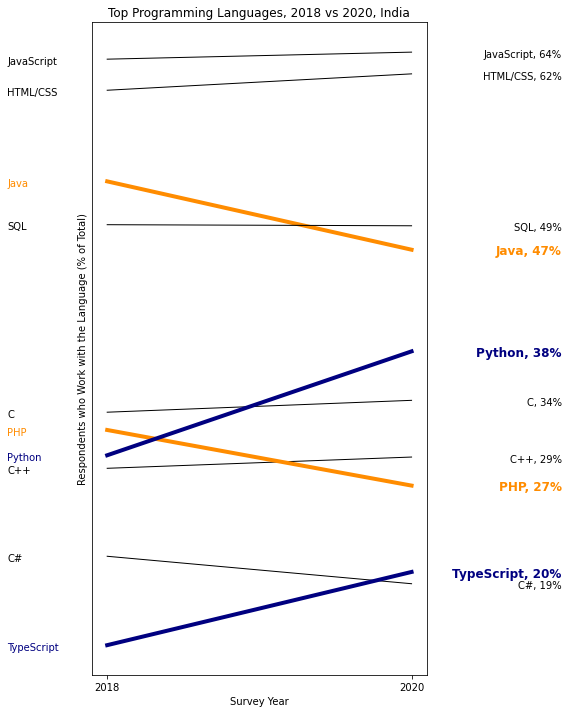

In [33]:
fig_india_top, ax_india_top, colors_india_top = plot_change(india_languages_filtered, 'Year', 'proportion', 'LanguageWorkedWith', 'Country', 'Top', 0.10)

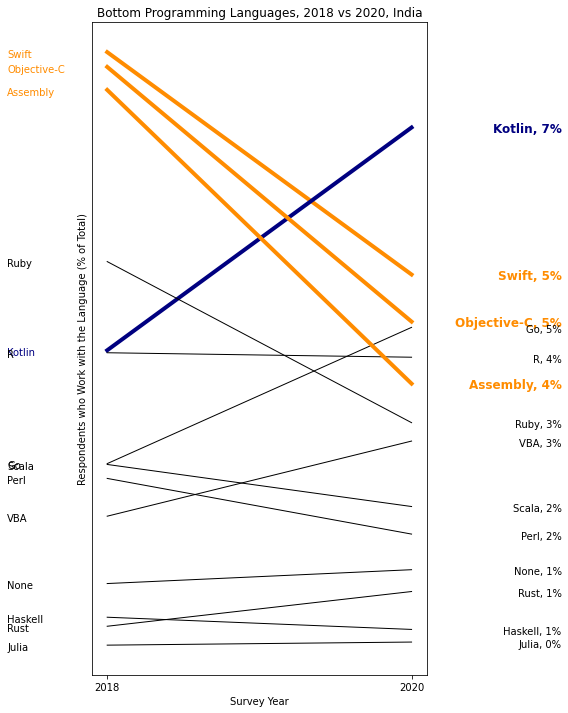

In [34]:
fig_india_bottom, ax_india_bottom, colors_india_bottom = plot_change(india_languages_filtered, 'Year', 'proportion', 'LanguageWorkedWith', 'Country', 'Bottom', 0.1)

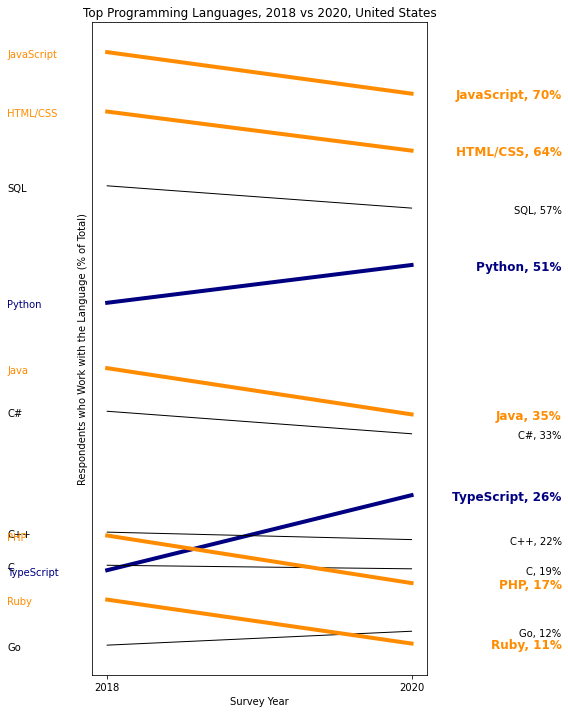

In [35]:
fig_us_top, ax_us_top, colors_us_top = plot_change(us_languages_filtered, 'Year', 'proportion', 'LanguageWorkedWith', 'Country', 'Top', 0.1)

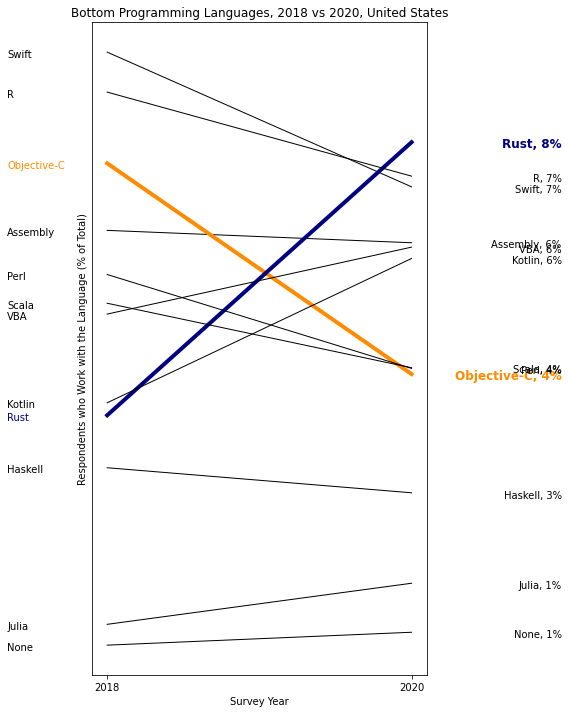

In [36]:
fig_us_bottom, ax_us_bottom, colors_us_bottom = plot_change(us_languages_filtered, 'Year', 'proportion', 'LanguageWorkedWith', 'Country', 'Bottom', 0.1)

### Business Question 1 Conclusions

Web front end and database query languages (HTML/CSS, JavaScript and SQL) are the top languages used in both countries in both years. Suggests commonality of front end skills among hobbyists and professionals and perhaps that backend skills are more esoteric.

In both countries, Python saw significant increase in users. This reflects the general perception that Python is an effective combination of "easy" and "useful" among programmers.

An interesting contrast between the US and India is that the US is uniquely seeing a rise in popularity among democratic, abstract languages in coincidence with a fall in popularity among more esoteric, lower-level languages. Hard to tell from this information alone, but this may reflect a rise in DIY culture in the US in the face of outsourcing more intensive programming roles to countries like India.

A final observation is the stability of what might be called "niche" programming languages like R, C++, and C. These are used by fewer than 40% of programmers in both countries, but their proportion has stayed constant from 2018-2021 while the proportions of other languages have changed significantly. This may suggest that these are languages that continue to have real, persistent use cases, but those use cases are rather esoteric and limited to specific types of roles.

### 6.2: How many languages do people in different fields know in each country?
- DevType is the field of interest.
- Also counts of LanguageWorkedWith

For this question, we can borrow df_india and df_us from above

They are already cleaned, and we can quantify known languages by taking len() of values in LanguageWorkedWith

We also only need to consider 2020 for this one. Current insight is interesting. Save change if this insight over time for another analysis.

In [37]:
# First, document the variables of interest
vars_of_interest_q2 = ['Year','Respondent','Country','DevType','LanguageWorkedWith']
# Next, create a single dataframe for ease of use that selects only vars of interest and includes both IN and US
# No need to run find_mutual_values(). We're only looking at 2020, so no need to standardize responses between years.
df_languageCount = pd.concat([df_india, df_us], axis =0)[vars_of_interest_q2]
df_languageCount = df_languageCount[df_languageCount.Year == '2020']

In [38]:
# Create count of languages known column.
df_languageCount['LanguageCount'] = df_languageCount['LanguageWorkedWith'].apply(lambda x: len(x))

In [39]:
# For each variable's analysis, remove NaN rows from dataset. If they didn't respond, sparse insights to be had in NaN segments.
df_language_devType = df_languageCount[['Respondent','Country','DevType','LanguageWorkedWith','LanguageCount']].dropna(subset = ['DevType']).reset_index(drop = True)
# Create lists in DevType column
df_language_devType['DevType'] = df_language_devType['DevType'].apply(lambda x: x.split(';'))

In [40]:
df_language_devType

,Respondent,Country,DevType,LanguageWorkedWith,LanguageCount
0,7,India,"[Developer, back-end, Developer, front-end, De...","[C#, HTML/CSS, PHP]",3
1,22,India,"[Developer, full-stack, Engineer, data]","[Java, Python]",2
2,58,India,"[Developer, back-end]","[C#, JavaScript, SQL, TypeScript]",4
3,63,India,"[Designer, Developer, back-end, Developer, fro...","[C, C++, HTML/CSS, Java, JavaScript, Python]",6
4,149,India,"[Developer, back-end, Developer, QA or test, D...","[Bash/Shell/PowerShell, C++, Perl]",3
...,...,...,...,...,...
13929,49544,United States,"[Data or business analyst, Data scientist or m...","[Bash/Shell/PowerShell, JavaScript, Python, SQ...",5
13930,53549,United States,"[Developer, full-stack, DevOps specialist, Pro...","[Bash/Shell/PowerShell, C#, HTML/CSS, Java, Py...",6
13931,53697,United States,"[Data or business analyst, Data scientist or m...","[Bash/Shell/PowerShell, Python, R, SQL]",4
13932,58498,United States,"[Data or business analyst, Developer, back-end...","[Assembly, Bash/Shell/PowerShell, C, C#, C++, ...",25


#### 6.2.1 Get counts of languages known by people who are of each devtype.

This actually feels more like an unsupervised learning problem where goal is creating segments of users based on collections of languages known. Not that far in the program yet, though. So, this method is simpler while still maybe being a bit insightful.

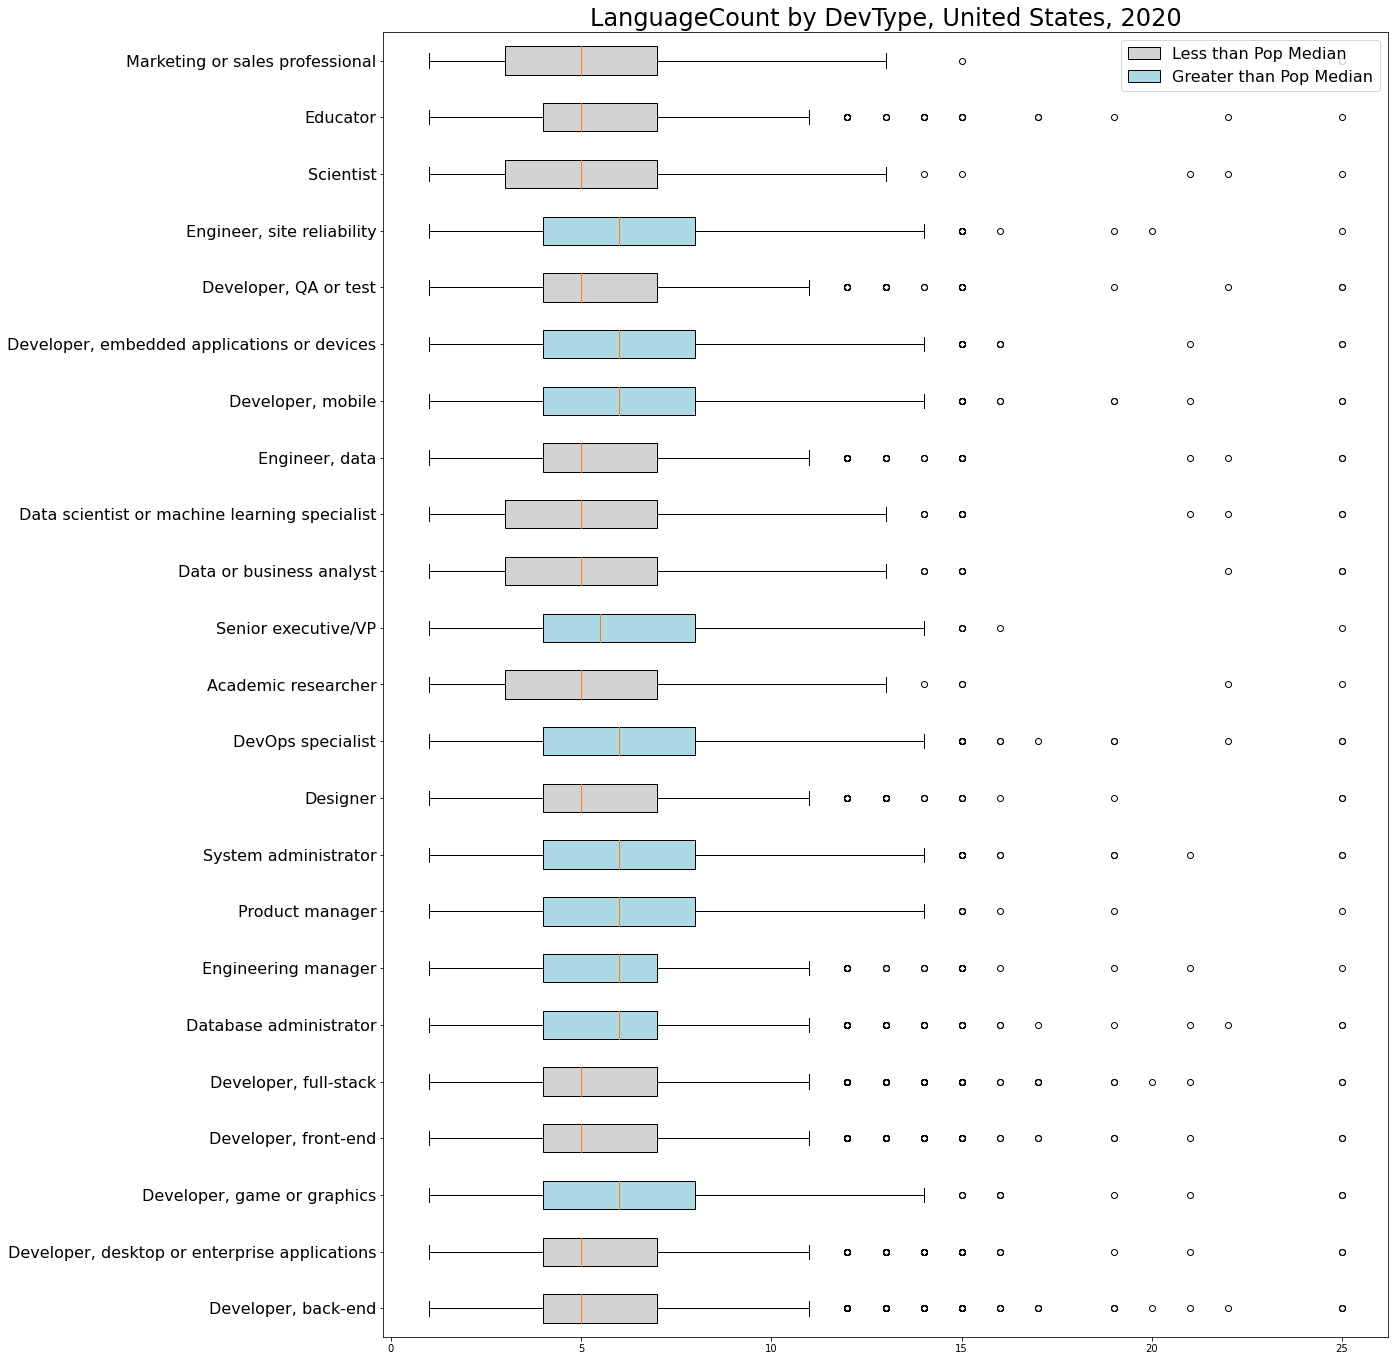

In [41]:
us_bplot, us_ax = plot_language_counts(df_language_devType, 'DevType', 'Country', ['United States'], 'LanguageCount', 'Median')

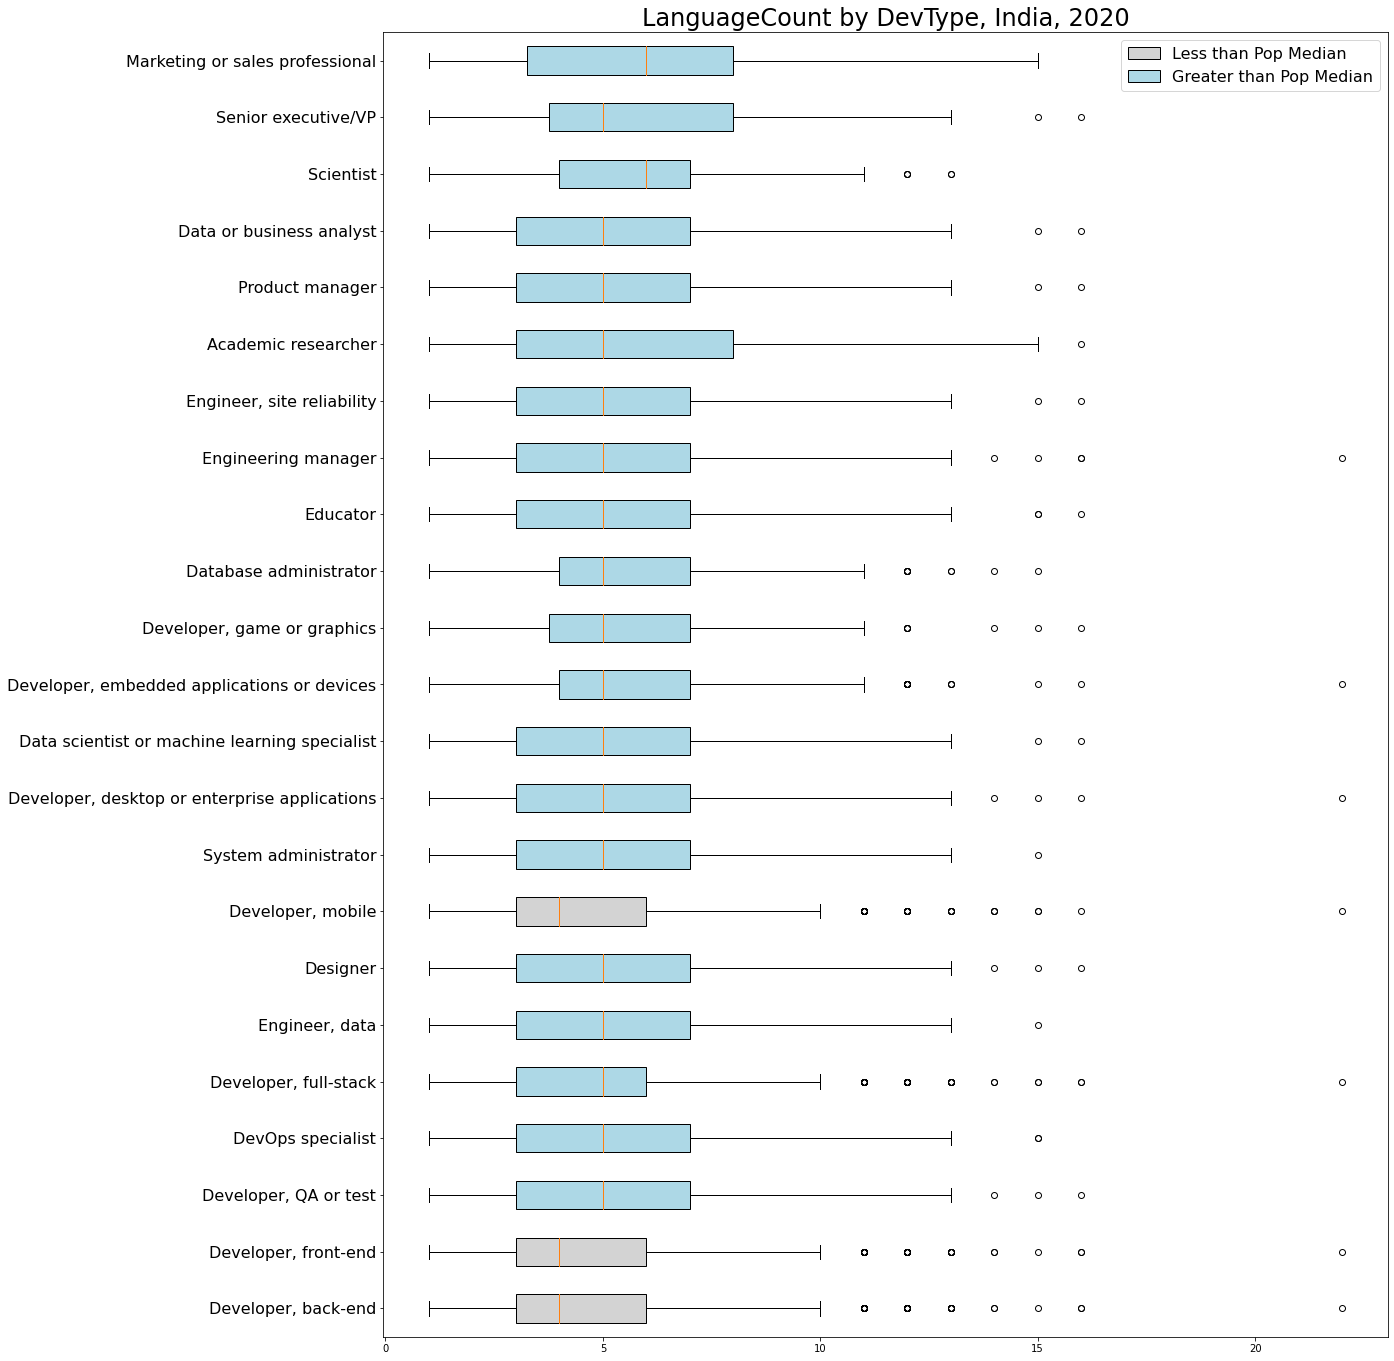

In [42]:
in_bplot, in_ax = plot_language_counts(df_language_devType, 'DevType', 'Country', ['India'], 'LanguageCount', 'Median')

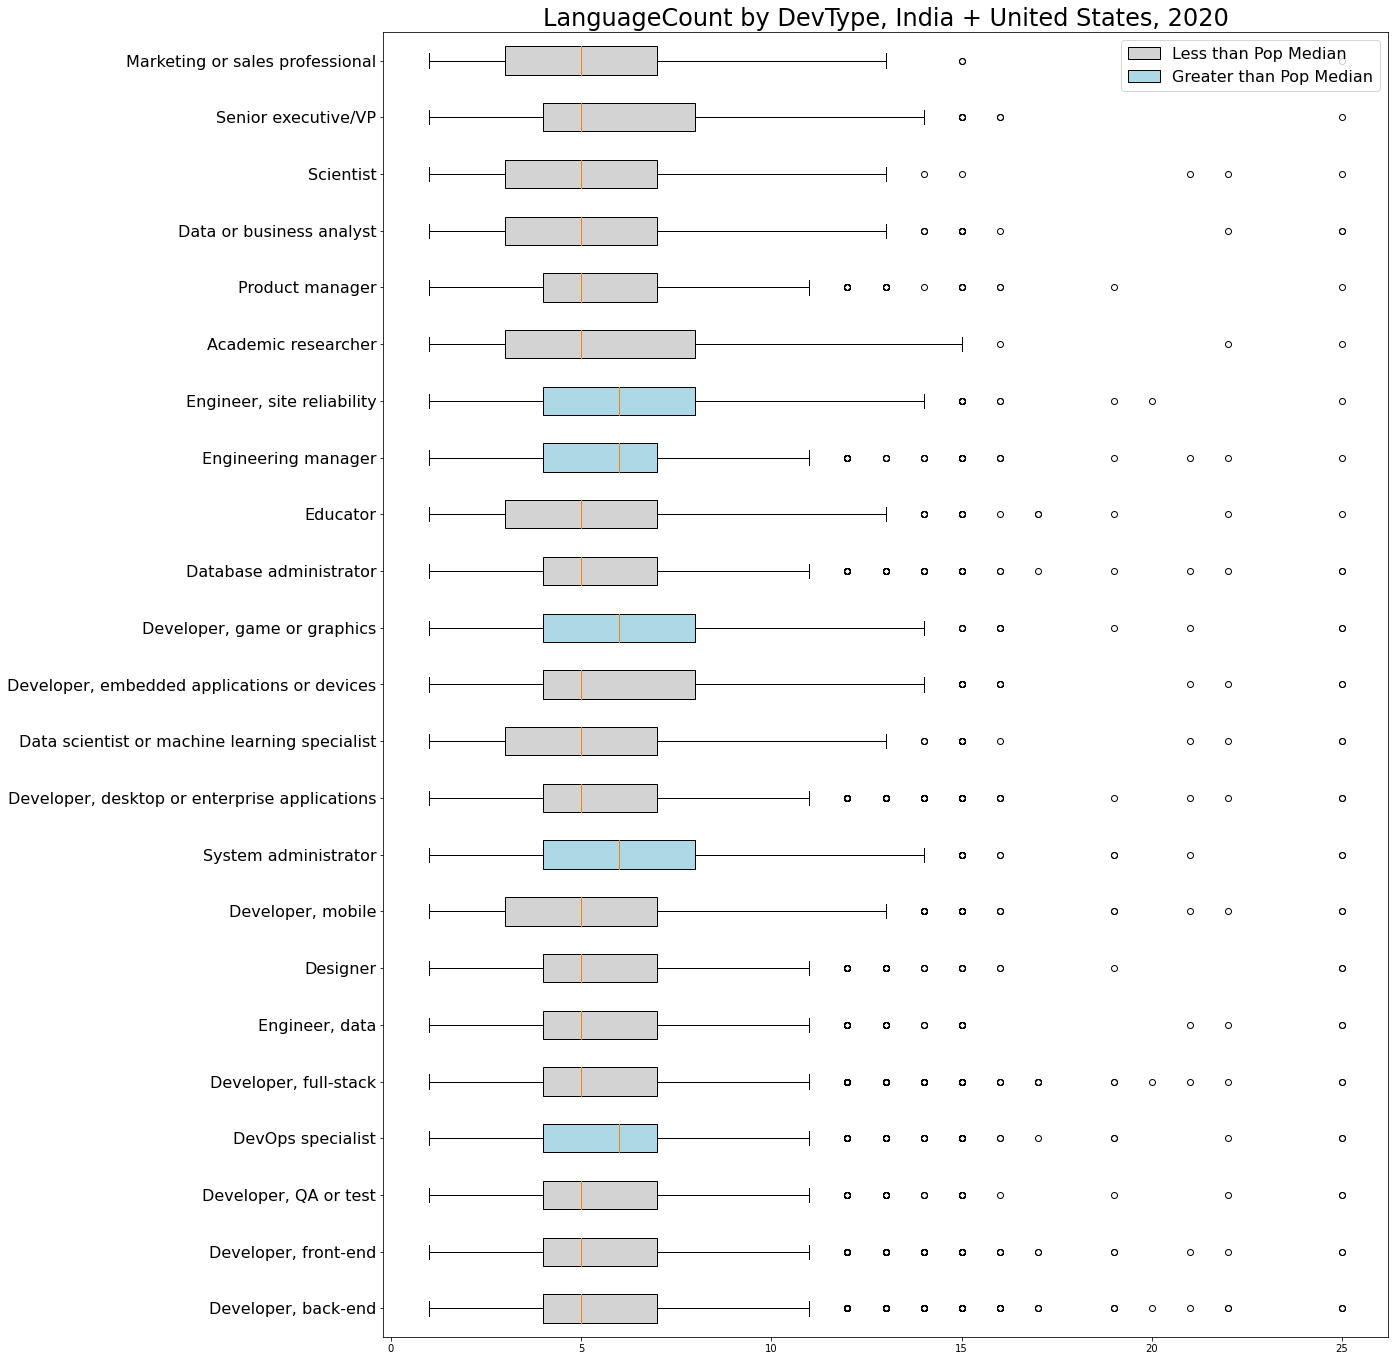

In [43]:
all_bplot, all_ax = plot_language_counts(df_language_devType, 'DevType', 'Country', ['India', 'United States'], 'LanguageCount', 'Median')

### Business Question 2 Conclusion

In the US, the norm for a developer type is to know and use around 5 languages (the median). There's something funny in the US results, though. Developer types reporting higher-than-median languages used are generalists and people who seem to have moved out of developer roles: Senior VPs, Product Manager, Engineering Managers, Database Admins. 

A good followup analysis would probe their ages and languages known--it seems possible that these people are veterans who know many languages after a career of accumulating them, but who no longer use them very often.

In India, most developer types know more than the median response value for count of languages known. The median is around 5, like the US, but most dev types are reporting knowing and using around 6 or sometimes more languages. This makes the dev types with lower medians more interesting. Mobile, Front-End and Back-End developers are the ones who know relatively few languages. Perhaps these fields are specialized enough that few languages are necessary, and/or these fields attract younger developers who are just on their first languages of their sure-to-be long careers.

### 6.3: Does preponderance of languages in LanguageDesireNextYear predict preponderance of future LanguageWorkedWith?

What I need to do:

1. Figure out which languages were desired but not known in each country in 2018
2. See if the most popular in that set coincide with the positive slopes in the slope graphs in question 1

In [44]:
# Desired by not know in each country, dataset requires LanguageWorkedWith, LanguageDesireNextYear, Country, Respondent
# Both columns are formatted as lists, already, so just need to concat df_us and df_india
vars_of_interest_q3 = ['Respondent','Country','Year','LanguageWorkedWith','LanguageDesireNextYear']
df_desired = pd.concat([df_us,df_india], axis = 0)[vars_of_interest_q3]
df_desired = df_desired[df_desired.Year == '2018'].reset_index(drop = True)

In [45]:
# Create LanguageMissing to document languages desired but not known in 2018.
df_desired['LanguageMissing'] = df_desired.apply(lambda x: [a for a in x['LanguageDesireNextYear'] if a not in x['LanguageWorkedWith']], axis = 1)
# Filter for LanguageMissing count > 0 to get people who wanted to learn new languages in 2018
# Use .map() method to apply a function to values in the column
df_newLearners = df_desired[df_desired.LanguageMissing.map(len) > 0]

In [46]:
# Find out how many new learners there were in 2018
(df_desired.shape[0] - df_newLearners.shape[0])/df_desired.shape[0]

0.2938563735702213

70% of respondents in 2018 wanted to learn a new language in 2019.

In [47]:
# Now, find observation counts for each language appearing in df_newLearners.LanguageMissing
# These are the "new languages" most desired by respondents in 2018
# We can use list_to_value_counts() from question 1

df_newLanguages = list_to_value_counts(df_desired, 'LanguageMissing', 'Country', transforms = transforms)

In [48]:
df_newLanguages.head()

,Country,LanguageMissing,count,proportion
0,India,VBA,54,0.005993
1,India,Delphi/Object Pascal,56,0.006215
2,India,Cobol,67,0.007435
3,India,Ocaml,74,0.008212
4,India,Visual Basic 6,92,0.010210


In [49]:
# Combine the color dicts we created for question 1 with plot_change() so that we can color charts below
# in a way that links this insight to our question 1 insight
colors_us = colors_us_top
colors_us.update(colors_us_bottom)

colors_india = colors_india_top
colors_india.update(colors_india_bottom)

In [60]:
def plot_desired_languages(df, segment_col, filter_col, filter_vals, count_col, colors_dict):
    """
    Takes a dataframe and returns a horizontal bar plot totaling count_col for each segment in segment_col.
    
    Args:
        df: Dataframe containing data of interest.
        segment_col: Column used to analyze the frame. Each value within will get its own bar in the final plot.
        filter_col: Column used to subset the frame.
        filter_vals: A list. Frame will be subset for values in this list in filter_col.
        count_col: The metric of interest to be plotted.
        colors_dict: A 1D dictionary that maps unique values in segment_col to colors. Ideal case is visually linking this
            analysis to a previous analysis (coloring bars the same way here that they were colored prior)
            
    Returns: A horizontal bar plot.
    """
    # Subset the dataframe to include only filtered vals from filter col and only values that appear in colors_dict
    # Colors dict is designed to come from plot_change(), but it's just a dict that maps segment values to desired bar colors
    df_filtered = df[(df[filter_col].isin(filter_vals)) & (df[segment_col].isin(colors_dict.keys()))].sort_values(by = [count_col], ascending = True).reset_index(drop = True)
    df_filtered['Color'] = df_filtered[segment_col].apply(lambda x: colors_dict[x])
    
    fig, ax = plt.subplots(figsize = (16,24))
    
    segments = list(df_filtered[segment_col])
    vals = list(df_filtered[count_col])
    colors = list(df_filtered['Color'])
    
    y_pos = list(range(0, len(segments)))
    
    ax.barh(y_pos, vals, align = 'center', color = colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(segments, fontsize = 16)
    
    plt.title('Most Common ' + segment_col + ', ' + ' + '.join(filter_vals) + ', 2018', fontsize = 24)
    
    plt.savefig('output/' + '-'.join(filter_vals) + '_' + segment_col + '.png')
    plt.show()
    
    return fig, ax

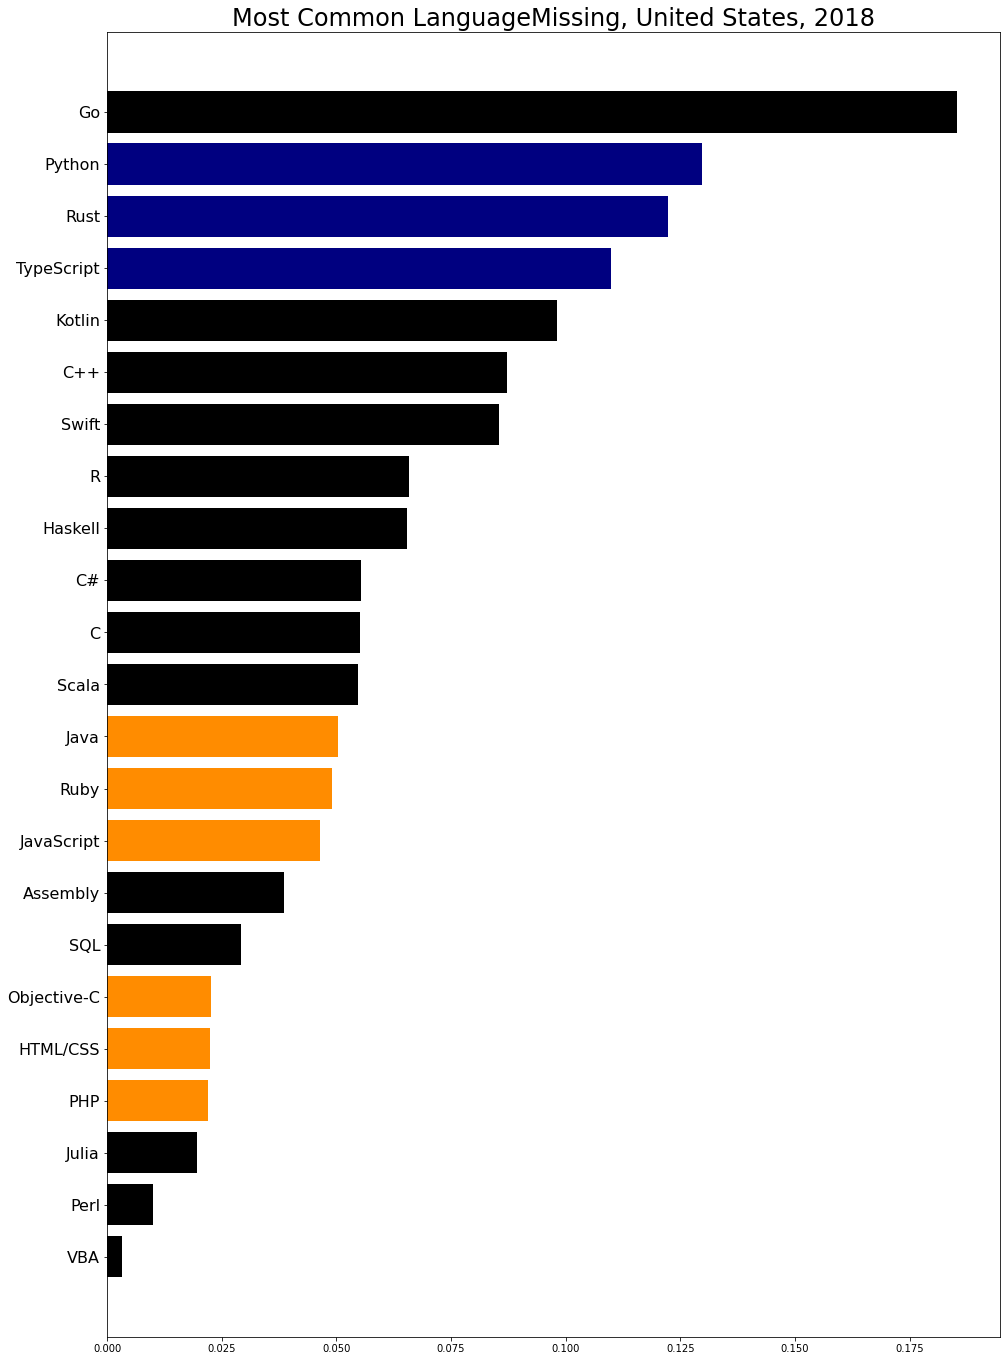

In [61]:
fig_us_missing, ax_us_missing = plot_desired_languages(df_newLanguages, 'LanguageMissing', 'Country', ['United States'], 'proportion', colors_us)

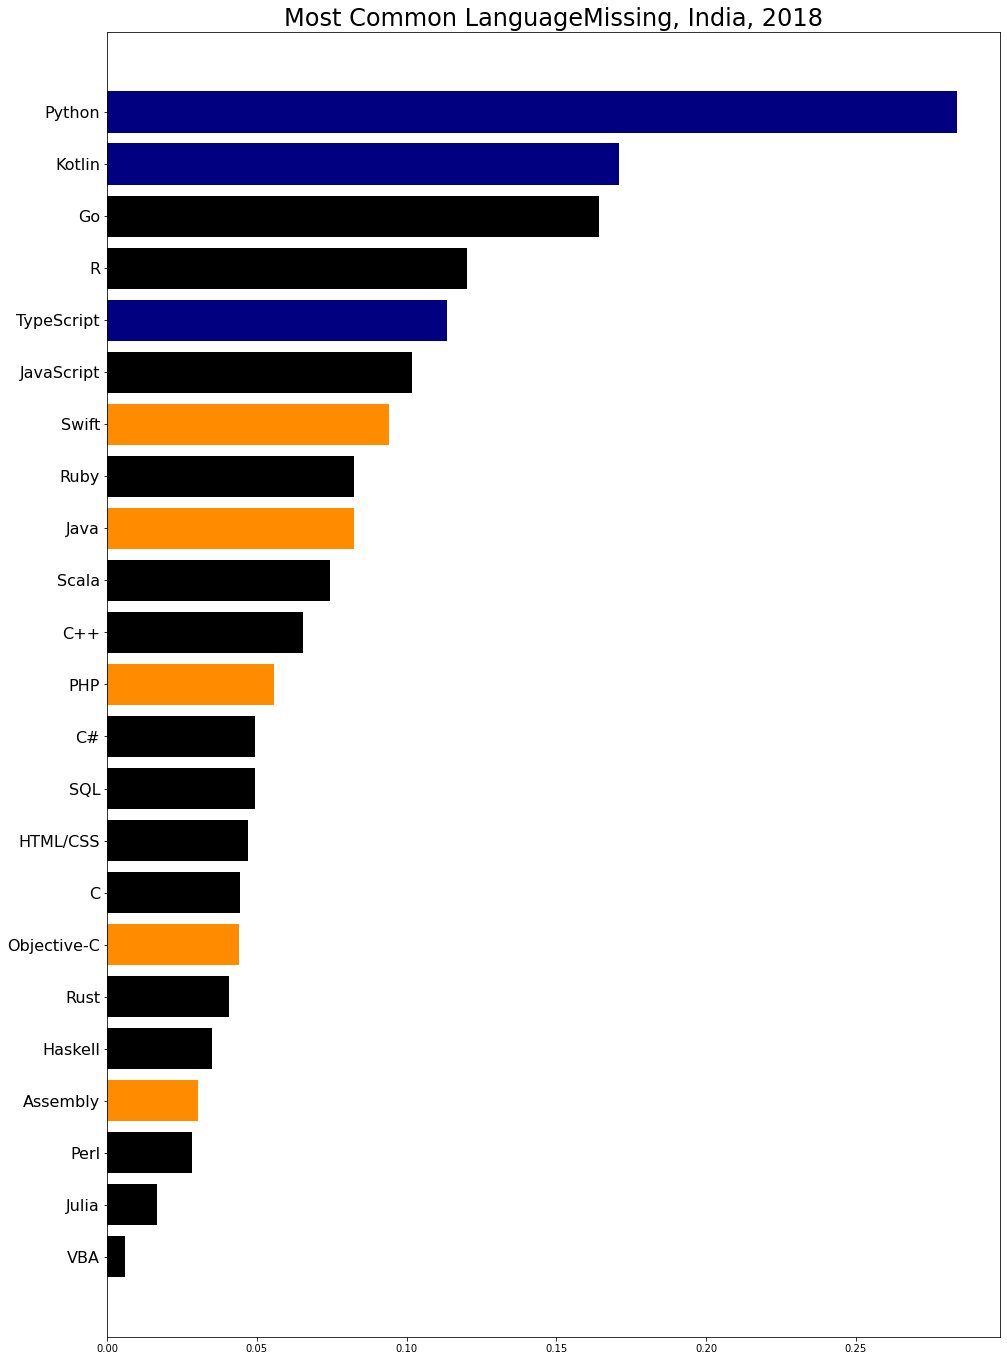

In [63]:
fig_in_missing, ax_in_missing = plot_desired_languages(df_newLanguages, 'LanguageMissing', 'Country', ['India'], 'proportion', colors_india)

### Business Question 3 Conclusions

It looks like, very generally, signals of learning intent in one year can suggest an increase in popularity for a language in coming years. In the cases of the US and India, languages that saw significant increases in popularity between 2018 and 2020 also saw many respondents desiring to learn them in 2018. In all of those cases, the languages that saw increases in popularity saw greater than 10% of respondents intending to learn them back in 2018.

There's a wrinkle, though. While this "greater than 10%" rule applies to some languages, it doesn't apply in all cases. Some languages popularly desired in 2018 saw only modest or no increases in popularity between 2018 and 2020.

From this analysis, I would take with me this idea: When we notice some languages in the high-response-count area for desired languages, we can imagine that *some* of them will see increases in popularity over the next few years. However, we'll need outside insight to be more confident regarding which of them will see the increase. Staying in touch with qualitative sources like Reddit could make sensemaking easier, in that regard.

Conversely, it would seem that no language seeing low desire among respondents will see significantly increased usage in the coming years.